In [1]:
import rascal
from rascal.representations import SphericalInvariants as SOAP

import ase
from ase import io
#from ase import atoms

import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

import soprano
from soprano.properties.nmr import *

import random

import soprano
from soprano.properties.nmr import *

import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from numpy.linalg import lstsq

import pandas as pd
from pandas import DataFrame

In [2]:
def keys_grabber(category):
    keys = list(pickle.load(open('Data/' + category + '/uid_index.pkl','rb')).keys())
    for i in keys:
        if not os.path.exists('Data/'+category+'/' + str(i) + '.magres'):
            keys.remove(i)
    return keys

def descriptor(cut, smooth):
    HYPERS = {
    'soap_type': 'PowerSpectrum',
    'interaction_cutoff': cut,
    'max_radial': 2,
    'max_angular': 6,
    'gaussian_sigma_constant': 0.5,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': smooth,
    'radial_basis': 'GTO',
    'inversion_symmetry': True,
    'normalize' : True
    }
    soap = SOAP(**HYPERS)
    return soap


def puller(keys, soap, category):
    #reading in all structures and creating all spectrums.
    for i in keys:
        #print(i)
        if keys.index(i) == 0:
            structure = ase.io.read('Data/' + category +'/'+str(i)+'.magres')
            spectrum = soap.transform(structure).get_features(soap)
            full_spec = spectrum
            iso = MSIsotropy.get(structure)
        else:
            structure = ase.io.read('Data/' + category +'/'+str(i)+'.magres')
            spectrum = soap.transform(structure).get_features(soap)
            full_spec = np.concatenate((full_spec,spectrum),axis =0)
            iso = np.concatenate((iso,MSIsotropy.get(structure)),axis=0)
    return full_spec, iso


def splitter(tr_f, no_sparse, full_spec, iso):
    #Randomly choosing representative matrix
    ids = range(len(full_spec)) #list of all ids
    tr_id = random.sample(ids, int(tr_f*len(full_spec)))
    sp_id = random.sample(tr_id, no_sparse)

    tr_sp = full_spec[tr_id] #training spectrums
    sp_sp = full_spec[sp_id] #representative/sparse spectrums

    tr_ta = iso[tr_id] #training target
    
    te_id = list(ids)
    for i in tr_id:
        te_id.remove(i)
    te_sp = full_spec[te_id]
    te_ta = iso[te_id]
    
    return sp_sp, tr_sp, tr_ta, te_sp, te_ta 
    
    
def kerneller(to_kernel, sp_sp, ker_exp):
    kernel = (to_kernel@sp_sp.T)**ker_exp
    return kernel



In [3]:
def model_accuracy(cat, cut, smo_cut, sp_size, ker_exp, reg):

    keys = keys_grabber(cat)
    soap = descriptor(cut, smo_cut)
    full_spec, iso = puller(keys, soap, cat)
    
    sp_sp, tr_sp, tr_ta, te_sp, te_ta = splitter(0.9, sp_size, full_spec, iso)
    
    KNM = kerneller(tr_sp, sp_sp, ker_exp)
    KMM = kerneller(sp_sp, sp_sp, ker_exp)
    KTM = kerneller(te_sp, sp_sp, ker_exp)
    res = lstsq(KNM.T @ KNM + reg * KMM, KNM.T @ tr_ta, rcond=None)
    c = res[0]
    pred = KTM @ c
    rmse = mean_squared_error(te_ta, pred, squared=False)

    
    return te_ta, pred, rmse

def species_splitter(target, predicted):
    o_tar = []
    o_pred = []
    si_tar = []
    si_pred = []
    for i in target:
        if i < 350:
            o_tar.append(i)
        else:
            si_tar.append(i)
    for i in predicted:
        if i < 350:
            o_pred.append(i)
        else:
            si_pred.append(i)
    return o_tar, si_tar, o_pred, si_pred


In [4]:
#Rattle
#Do a 10 fold CV then get distribution of errors
cat='Rattle'
cut = 3.5
smo_cut = 1
sp_size = 1000
ker_exp = 20
reg = 1*10**-8
counter = 0

while counter < 10:
    temp_ta, temp_pr, rmse = model_accuracy(cat, cut, smo_cut, sp_size, ker_exp, reg)
    if counter == 0:
        target_r = temp_ta
        predicted_r = temp_pr
    else:
        target_r = np.concatenate((target_r, temp_ta))
        predicted_r = np.concatenate((predicted_r, temp_pr))
        
    counter += 1
    


o_tar_r, si_tar_r, o_pred_r, si_pred_r = species_splitter(target_r, predicted_r)

df_ro = pd.DataFrame()
df_ro['target'] = o_tar_r
df_ro['predicted'] = o_pred_r
df_ro['error'] = df_ro['predicted'] - df_ro['target']

df_rs = pd.DataFrame()
df_rs['target'] = si_tar_r
df_rs['predicted'] = si_pred_r
df_rs['error'] = df_rs['predicted'] - df_rs['target']


In [5]:
#HypoZeo
cut = 4
smo_cut = 0.5
sp_size = 1000
ker_exp = 25
reg = 1*10**-8
cat = 'HypoZeo'
counter = 0


while counter < 10:
    temp_ta, temp_pr, rmse = model_accuracy(cat, cut, smo_cut, sp_size, ker_exp, reg)
    if counter == 0:
        target_h = temp_ta
        predicted_h = temp_pr
    else:
        target_h = np.concatenate((target_h, temp_ta))
        predicted_h = np.concatenate((predicted_h, temp_pr))
        
    counter += 1
    #print(counter)


o_tar_h, si_tar_h, o_pred_h, si_pred_h = species_splitter(target_h, predicted_h)

df_ho = pd.DataFrame()
df_ho['target'] = o_tar_h
df_ho['predicted'] = o_pred_h
df_ho['error'] = df_ho['predicted'] - df_ho['target']

df_hs = pd.DataFrame()
df_hs['target'] = si_tar_h
df_hs['predicted'] = si_pred_h
df_hs['error'] = df_hs['predicted'] - df_hs['target']

In [7]:
#Amorphous - 0K
cut = 3.5
smo_cut = 1
sp_size = 1000
ker_exp = 10
reg = 1*10**-5
cat = 'AM0K'
counter = 0

while counter < 10:
    temp_ta, temp_pr, rmse = model_accuracy(cat, cut, smo_cut, sp_size, ker_exp, reg)
    if counter == 0:
        target_a = temp_ta
        predicted_a = temp_pr
    else:
        target_a = np.concatenate((target_a, temp_ta))
        predicted_a = np.concatenate((predicted_a, temp_pr))
        
    counter += 1
    #print(counter)


o_tar_a0, si_tar_a0, o_pred_a0, si_pred_a0 = species_splitter(target_a, predicted_a)

df_a0o = pd.DataFrame()
df_a0o['target'] = o_tar_a0
df_a0o['predicted'] = o_pred_a0
df_a0o['error'] = df_a0o['predicted'] - df_a0o['target']

df_a0s = pd.DataFrame()
df_a0s['target'] = si_tar_a0
df_a0s['predicted'] = si_pred_a0
df_a0s['error'] = df_a0s['predicted'] - df_a0s['target']

In [9]:
#Amorphous- 300K
cut = 3.5
smo_cut = 1
sp_size = 1000
ker_exp = 25
reg = 1*10**-8
cat = 'AM300K'
counter = 0

while counter < 10:
    temp_ta, temp_pr, rmse = model_accuracy(cat, cut, smo_cut, sp_size, ker_exp, reg)
    if counter == 0:
        target_a = temp_ta
        predicted_a = temp_pr
    else:
        target_a = np.concatenate((target_a, temp_ta))
        predicted_a = np.concatenate((predicted_a, temp_pr))
        
    counter += 1
    #print(counter)


o_tar_a3, si_tar_a3, o_pred_a3, si_pred_a3 = species_splitter(target_a, predicted_a)

df_a3o = pd.DataFrame()
df_a3o['target'] = o_tar_a3
df_a3o['predicted'] = o_pred_a3
df_a3o['error'] = df_a3o['predicted'] - df_a3o['target']

df_a3s = pd.DataFrame()
df_a3s['target'] = si_tar_a3
df_a3s['predicted'] = si_pred_a3
df_a3s['error'] = df_a3s['predicted'] - df_a3s['target']

In [10]:
#MD - Distorted
cut = 3.5
smo_cut = 1
sp_size = 1000
ker_exp = 25
reg = 1*10**-8
cat = 'MD_Distorted'
counter = 0

while counter < 10:
    temp_ta, temp_pr, rmse = model_accuracy(cat, cut, smo_cut, sp_size, ker_exp, reg)
    if counter == 0:
        target_a = temp_ta
        predicted_a = temp_pr
    else:
        target_a = np.concatenate((target_a, temp_ta))
        predicted_a = np.concatenate((predicted_a, temp_pr))
        
    counter += 1
    #print(counter)


o_tar_m, si_tar_m, o_pred_m, si_pred_m = species_splitter(target_a, predicted_a)

df_mo = pd.DataFrame()
df_mo['target'] = o_tar_m
df_mo['predicted'] = o_pred_m
df_mo['error'] = df_mo['predicted'] - df_mo['target']

df_ms = pd.DataFrame()
df_ms['target'] = si_tar_m
df_ms['predicted'] = si_pred_m
df_ms['error'] = df_ms['predicted'] - df_ms['target']

Text(0, 0.5, 'Absolute error (ppm)')

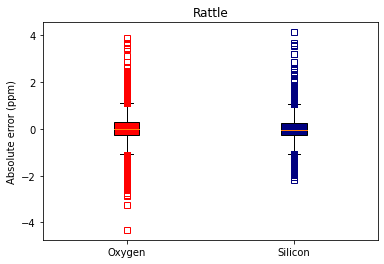

In [14]:
#rattle
plt.boxplot(df_ro['error'], positions = [1], labels=['Oxygen'],
           sym='s',patch_artist=True, boxprops=dict(facecolor='red'),
           flierprops=dict(markeredgecolor='red'))
plt.boxplot(df_rs['error'], positions = [2], labels=['Silicon'],
           sym='s',patch_artist=True, boxprops=dict(facecolor='navy'),
           flierprops=dict(markeredgecolor='navy'))
plt.title('Rattle')
plt.ylabel('Absolute error (ppm)')

Text(0, 0.5, 'Absolute error (ppm)')

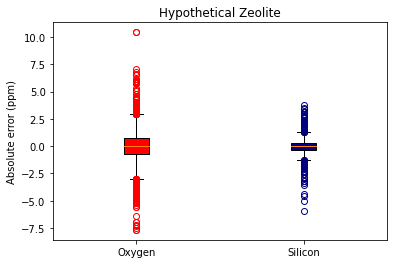

In [15]:
#hypozeo
plt.boxplot(df_ho['error'], positions = [1], labels=['Oxygen'],
           sym='o',patch_artist=True, boxprops=dict(facecolor='red'),
           flierprops=dict(markeredgecolor='red'))
plt.boxplot(df_hs['error'], positions = [2], labels=['Silicon'],
           sym='o',patch_artist=True, boxprops=dict(facecolor='navy'),
           flierprops=dict(markeredgecolor='navy'))
plt.title('Hypothetical Zeolite')
plt.ylabel('Absolute error (ppm)')

Text(0, 0.5, 'Absolute error (ppm)')

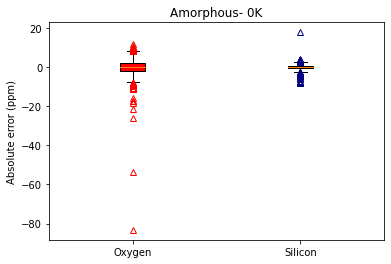

In [12]:
#amorphous - 0k

plt.boxplot(df_a0o['error'], positions = [1], labels=['Oxygen'],
           sym='^',patch_artist=True, boxprops=dict(facecolor='red'),
           flierprops=dict(markeredgecolor='red'))
plt.boxplot(df_a0s['error'], positions = [2], labels=['Silicon'],
           sym='^',patch_artist=True, boxprops=dict(facecolor='navy'),
           flierprops=dict(markeredgecolor='navy'))

plt.title('Amorphous- 0K')
plt.ylabel('Absolute error (ppm)')
#This could be used to make the point that although mean error outlier may fuck shit up.
#Look at why some silicon enviroments are so wrong.

Text(0, 0.5, 'Absolute error (ppm)')

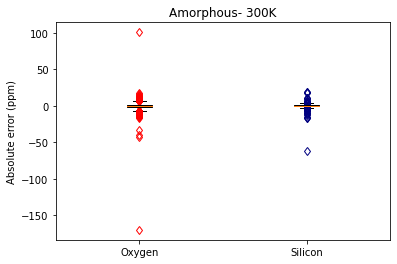

In [16]:
#Amorphous- 300K

plt.boxplot(df_a3o['error'], positions = [1], labels=['Oxygen'],
           sym='d',patch_artist=True, boxprops=dict(facecolor='red'),
           flierprops=dict(markeredgecolor='red'))
plt.boxplot(df_a3s['error'], positions = [2], labels=['Silicon'],
           sym='d',patch_artist=True, boxprops=dict(facecolor='navy'),
           flierprops=dict(markeredgecolor='navy'))

plt.title('Amorphous- 300K')
plt.ylabel('Absolute error (ppm)')

Text(0, 0.5, 'Absolute error (ppm)')

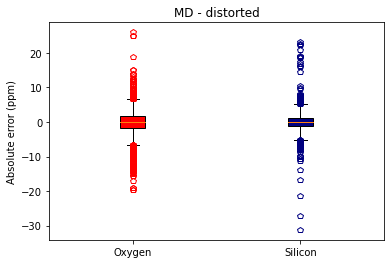

In [17]:
#MD- distorted

plt.boxplot(df_mo['error'], positions = [1], labels=['Oxygen'],
           sym='p',patch_artist=True, boxprops=dict(facecolor='red'),
           flierprops=dict(markeredgecolor='red'))
plt.boxplot(df_ms['error'], positions = [2], labels=['Silicon'],
           sym='p',patch_artist=True, boxprops=dict(facecolor='navy'),
           flierprops=dict(markeredgecolor='navy'))

plt.title('MD - distorted')
plt.ylabel('Absolute error (ppm)')

Text(0, 0.5, 'Absolute error (ppm)')

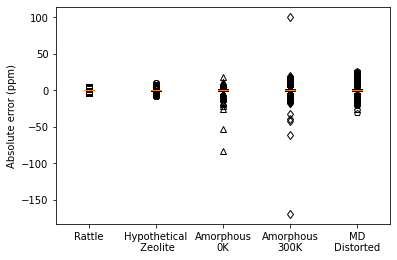

In [25]:
df_r = pd.concat([df_rs, df_ro])
df_h = pd.concat([df_hs, df_ho])
df_a0 = pd.concat([df_a0s, df_a0o])
df_a3 = pd.concat([df_a3s, df_a3o])
df_m = pd.concat([df_ms, df_mo])

plt.boxplot(df_r['error'], positions = [1], labels=['Rattle'],
            sym='s')
plt.boxplot(df_h['error'], positions = [2], labels=['Hypothetical\n Zeolite'],
            sym='o')
plt.boxplot(df_a0['error'], positions = [3], labels=['Amorphous\n0K'],
           sym='^')
plt.boxplot(df_a3['error'], positions = [4], labels=['Amorphous\n300K'],
            sym='d')
plt.boxplot(df_m['error'], positions = [5], labels=['MD\nDistorted'],
            sym='p')

plt.ylabel('Absolute error (ppm)')

Text(0, 0.5, 'Absolute error (ppm)')

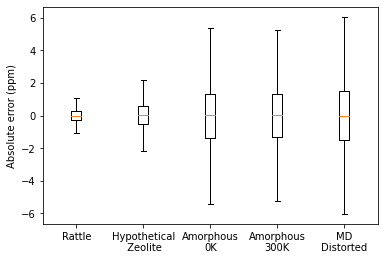

In [26]:
plt.boxplot(df_r['error'], positions = [1], labels=['Rattle'],
            sym='')
plt.boxplot(df_h['error'], positions = [2], labels=['Hypothetical\n Zeolite'],
            sym='')
plt.boxplot(df_a0['error'], positions = [3], labels=['Amorphous\n0K'],
           sym='')
plt.boxplot(df_a3['error'], positions = [4], labels=['Amorphous\n300K'],
            sym='')
plt.boxplot(df_m['error'], positions = [5], labels=['MD\nDistorted'],
            sym='')

plt.ylabel('Absolute error (ppm)')